In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import  DictVectorizer

In [5]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import root_mean_squared_error

In [6]:
def wrangle(filename):
    ##
    df = pd.read_parquet(filename)
    print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} columns')
    tot_rows = df.shape[0]

    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime) 
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime) 

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime

    df['duration'] = df['duration'].apply(lambda td: td.seconds/60)

    print(f'The standard deviation of duration column is {df['duration'].std().round(4)}')

    df = df[df['duration'].between(1, 60)]

    print(f'After removing duration below 1 minute/above 60 minutes, the proportion remaining is {round(df.shape[0]/tot_rows , 2)}')


    return df

In [7]:
january = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'
february = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'
df = wrangle(january)

df_val = wrangle(february)
df_val.shape

The dataset contains 3066766 rows and 19 columns
The standard deviation of duration column is 41.6292
After removing duration below 1 minute/above 60 minutes, the proportion remaining is 0.98
The dataset contains 2913955 rows and 19 columns
The standard deviation of duration column is 44.3467
After removing duration below 1 minute/above 60 minutes, the proportion remaining is 0.98


(2855951, 20)

In [8]:
print(f'The standard deviation of duration column is {df['duration'].std().round(4)}')

The standard deviation of duration column is 9.9394


In [9]:
df['duration'].describe().round(2)

count    3009176.00
mean          14.20
std            9.94
min            1.00
25%            7.22
50%           11.55
75%           18.18
max           60.00
Name: duration, dtype: float64

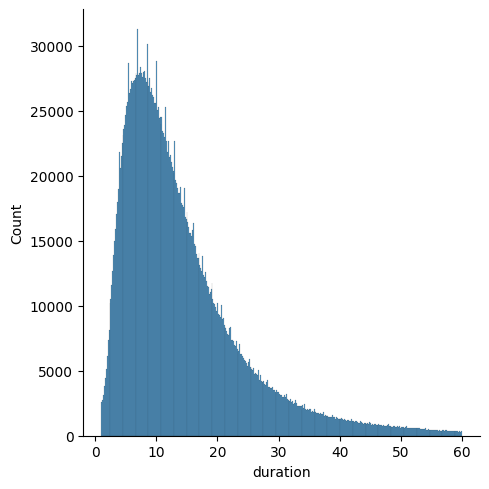

In [10]:
sns.displot(df['duration'])

In [19]:
# The plot above indicates the presence of outliers
# Let us remove it
df = df[df['duration'].between(1, 60)]
df.shape

(3009176, 20)

In [21]:
print(f'After removing duration below 1 minute/above 60 minutes, the proportion remaining is {round(df.shape[0]/3066766 , 2)}')

After removing duration below 1 minute/above 60 minutes, the proportion remaining is 0.98


In [11]:
def train_model(df):

    categorical = ['PULocationID',	'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)
    train_dicts = df[categorical + numerical].to_dict(orient= 'records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(train_dicts)
 
    print(f'The feature matrix has {X_train.shape[1]} columns')
    target = 'duration'
    y_train =df[target].values

    model_lin = LinearRegression()
    model_lasso = Lasso()
    model_lin.fit(X_train, y_train)
    model_lasso.fit(X_train, y_train)

    y_pred_lr = model_lin.predict(X_train)
    y_pred_lasso = model_lasso.predict(X_train)
    rmse1 = root_mean_squared_error(y_train, y_pred_lr)
    rmse2 = root_mean_squared_error(y_train, y_pred_lasso)
    return {
            'X_train': X_train, 
            'y_train': y_train, 
            'rmse linear regression': rmse1, 
            'rmse lasso regression': rmse2, 
            'model1': model_lin
            }

    


In [12]:
ma = train_model(df)
ma

The feature matrix has 516 columns


{'X_train': <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 9027528 stored elements and shape (3009176, 516)>,
 'y_train': array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
        13.        , 14.4       ], shape=(3009176,)),
 'rmse linear regression': 7.658403829355429,
 'rmse lasso regression': 9.938398501183862,
 'model1': LinearRegression()}

/tmp/ipykernel_99233/1013725182.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ma['model1'].predict(ma['X_train']), label= 'predictions')
/tmp/ipykernel_99233/1013725182.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ma['y_train'], label= 'actual')


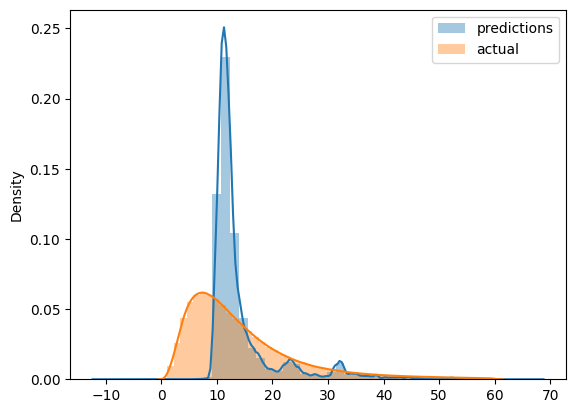

In [14]:
sns.distplot(ma['model1'].predict(ma['X_train']), label= 'predictions')
sns.distplot(ma['y_train'], label= 'actual')

plt.legend()

In [15]:
print(f'The rmse of the LinearRegression model on a train set is {ma['rmse linear regression']}')

The rmse of the LinearRegression model on a train set is 7.658403829355429


In [16]:
categorical = ['PULocationID',	'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)
train_dicts = df[categorical + numerical].to_dict(orient= 'records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)


df_val[categorical] = df_val[categorical].astype(str)
val_dicts = df_val[categorical + numerical].to_dict(orient= 'records')

X_val = dv.transform(val_dicts)




In [17]:
y_val = df_val['duration'].values

y_pred = ma['model1'].predict(X_val)
rmse_val = root_mean_squared_error(y_val, y_pred)



In [18]:
print(f'The rmse of the LinearRegression model on a validation set is {rmse_val}')

The rmse of the LinearRegression model on a validation set is 7.819986816765688
